Reference (출처, 참고 사이트)

- https://arxiv.org/pdf/1706.03762 (Attention Is All You Need, 논문)

- https://github.com/daehwichoi/transformer-pytorch/blob/main/model/transformer.py (코드)

- https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb (코드)

- https://velog.io/@heiswicked/%ED%86%A0%EC%B9%98%EC%9D%98-%ED%98%B8%ED%9D%A1-06-About-Transformer-PART-01-PositionalEncodingLayer (이론 & 코드)

- https://yangoos57.github.io/blog/DeepLearning/paper/Transformer/Transformer_From_Scratch (이론 & 코드)
    - https://github.com/yangoos57/Transformer_from_scratch/blob/main/%5Btutorial%5D%20training%08transformer%20.ipynb (코드)

- https://cpm0722.github.io/pytorch-implementation/transformer (이론 & 코드)
    - https://github.com/cpm0722/transformer_pytorch/blob/main/models/model/transformer.py (코드)

- https://github.com/loggerJK/transformer-implementation/blob/master/Training.ipynb (코드)

# Modeling

## 모듈 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Multi-Head Attention

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, head_num, device):
        super().__init__()

        assert d_model % head_num == 0 # 나누어 떨어지지 않으면 오류

        self.d_model = d_model # concat한 후의 차원
        self.head_num = head_num # head의 개수

        self.head_dim = d_model // head_num # 각 헤드에서의 임베딩 차원

        self.W_Q = nn.Linear(d_model, d_model) # Query 값에 적용될 가중치
        self.W_K = nn.Linear(d_model, d_model) # Key 값에 적용될 가중치
        self.W_V = nn.Linear(d_model, d_model) # Value 값에 적용될 가중치

        self.W_O = nn.Linear(d_model, d_model) # W_O에 해당하는 가중치

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q: [batch_size, head_num, query_len, head_dim]
        # K: [batch_size, head_num, key_len, head_dim]
        # V: [batch_size, head_num, value_len(=key_len), head_dim]

        d_K = K.size(-1)
        scale = torch.sqrt(torch.FloatTensor([d_K])).to(device)
        scaled_matmul = torch.matmul(Q, torch.transpose(K, -1, -2)) / scale
        # output: [batch_size, head_num, query_len, key_len]

        if mask is not None: # mask를 사용한다면
            '''
            input_mask: [batch_size, 1, 1, seq_len]
            output_mask: [batch_size, 1, seq_len, seq_len]
            '''
            scaled_matmul = scaled_matmul.masked_fill(mask==0, float('-inf'))

        attention_weights = torch.softmax(scaled_matmul, dim=-1)# row-wise softmax: 각 단어에 대한 확률 값
        # attention_weights: [batch_size, head_num, query_len, key_len]
        output = torch.matmul(attention_weights, V)
        # output: [batch_size, head_num, query_len, head_dim]

        return output

    # 처음부터 concat이 되어 있는 것처럼 한 후에 shape를 맞추는 방식으로 구현
    # Self-Attention, Cross-Attention 모두 적용해야 하므로 Q, K, V를 따로 받는다
    def forward(self, Q, K, V, mask=None):
        # Q: [batch_size, query_len, d_model]
        # K: [batch_size, key_len, d_model]
        # V: [batch_size, value_len, d_model]
        # Self Attention에서는 query_len = key_len = value_len = seq_len
        # Encoder-Decoder Attention에서는 key_len = value_len = enc_out_seq_len
        # query_len: query 자체의 개수 != d_q: query의 임베딩 차원

        batch_size = Q.size(0)

        # 1. W_Q, W_K, W_V 적용 후 Head 나누기
        # d_model = head_num x head_dim
        Q = self.W_Q(Q).view(batch_size, -1, self.head_num, self.head_dim).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.head_num, self.head_dim).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.head_num, self.head_dim).transpose(1, 2)
        ## nn.Linear(float)와 dtype을 맞추어야 해서 q, k, v의 dtype 변환

        # 변환 후
        # Q: [batch_size, head_num, query_len, head_dim]
        # K: [batch_size, head_num, key_len, head_dim]
        # V: [batch_size, head_num, value_len, head_dim]

        # 2. Scaled Dot-Product Attention 적용
        scaled_attention = self.scaled_dot_product_attention(Q, K, V, mask)
        # scaled_attention: [batch_size, head_num, query_len, head_dim]

        # 3. Head concat 과정
        concat_attention = torch.transpose(scaled_attention, 1, 2).contiguous().view(batch_size, -1, self.d_model)
        # transpose 이후: [batch_size, query_len, head_num, head_dim]
        # concat_attention: [batch_size, query_len, d_model]

        # 4. W_O 적용
        output = self.W_O(concat_attention)
        # output: [batch_size, query_len, d_model]

        return output

## Position-wise Feed Forward

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, ff_dim):
        # ff_dim: FeedForward layer에서의 내부 임베딩 차원
        super().__init__()

        self.fc_1 = nn.Linear(d_model, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, d_model)

    def forward(self, input):
        # input: [batch_size, seq_len, d_model]
        output = torch.relu(self.fc_1(input))
        output = self.fc_2(output)
        # output: [batch_size, seq_len, d_model]

        return output

## Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, head_num, ff_dim, dropout_p, device):
        super().__init__()

        self.self_attention_layer_norm = nn.LayerNorm(d_model) # Multi-Head Attention 이후 Layer Normalization
        self.ff_layer_norm = nn.LayerNorm(d_model) # Feed Forward 이후 Layer Normalization

        self.self_attention = MultiHeadAttention(d_model, head_num, device)
        self.positionwise_feedforward = PositionwiseFeedForward(d_model, ff_dim)

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, query, key, value, input_mask):
        # query: [batch_size, seq_len, d_model]
        # key: [batch_size, seq_len, d_model]
        # value: [batch_size, seq_len, d_model]
        # input_mask: [batch_size, 1, 1, seq_len]

        # 1. Self attention
        multihead_output = self.self_attention(query, key, value, input_mask)

        # 2. Dropout, residual connection and layer normalization
        # Add&Norm을 하기 전에 sub-layer output에 dropout을 한다.
        residual_1_output = self.self_attention_layer_norm(query + self.dropout(multihead_output))
        # residual_1_output: [batch_size, seq_len, d_model]

        # 3. Position-wise feed forward
        feedforward_output = self.positionwise_feedforward(residual_1_output)

        # 4. Dropout, residual connection and layer normalization
        # Add&Norm을 하기 전에 sub-layer output에 dropout을 한다.
        output = self.ff_layer_norm(residual_1_output + self.dropout(feedforward_output))

        # output: [batch_size, seq_len, d_model]

        return output

## Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, layer_num, head_num, ff_dim, dropout_p, device, max_length):
        super().__init__()

        self.device = device

        self.input_embedding = nn.Embedding(input_dim, d_model) # (입력 단어의 가짓수, 임베딩 크기)
        self.layers = nn.ModuleList([EncoderLayer(d_model, head_num, ff_dim, dropout_p, device) for _ in range(layer_num)])
        self.dropout = nn.Dropout(dropout_p)
        self.d_model = d_model

        self.max_length = max_length

    def position_encoding(self, position_max_length):
        position = torch.arange(0, position_max_length, dtype=torch.float).unsqueeze(1)
        # position: [position_max_length, 1]
        pe = torch.zeros(position_max_length, self.d_model)
        # pe: [position_max_length, d_model]
        '''
        원래대로 구현하면 다음과 같으나, 오버플로 방지를 위해 역수를 취해서 식을 변형
        div_term = torch.pow(torch.ones(self.d_model // 2).fill_(10000),
                             torch.arange(0, self.d_model, 2) / torch.tensor(self.d_model, dtype=torch.float32))

        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        '''
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * -(torch.log(torch.Tensor([10000.0])) / self.d_model))
        # div_term: [d_model // 2]

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # pe: [1, position_max_length, d_model]

        pe.requires_grad = False # 학습 대상 아님

        return pe

    def forward(self, input, input_mask):
        # input: [batch_size, seq_len]
        # input_mask: [batch_size, 1, 1, seq_len]

        input_embedding = self.input_embedding(input.long()) # dtype을 바꿔서 오류가 안 나도록
        # input_embedding: [batch_size, seq_len, d_model]

        # input embedding 후 결과와 position encoding을 합친 후 dropout 적용
        encoder_input = self.dropout(input_embedding +
                                     self.position_encoding(self.max_length).to(self.device)[:, :input.size(-1), :]) ## embedding된 input과 차원을 맞추어야 한다.
        # encoder_input: [batch_size, seq_len, d_model]

        # 모든 EncoderLayer를 거치면서 순전파 수행
        for layer in self.layers:
            output = layer(encoder_input, encoder_input, encoder_input, input_mask)
            # output: [batch_size, seq_len, d_model]

        return output

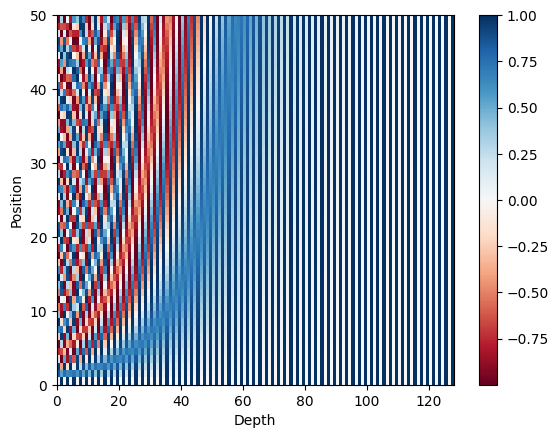

In [7]:
example_enc = Encoder(1000, 128, 6, 8, 2048, 0.1, 140, device)
pe = example_enc.position_encoding(140)[:, :50, :].squeeze()

import matplotlib.pyplot as plt

plt.pcolormesh(pe, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Decoder Layer

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, head_num, ff_dim, dropout_p, device):
        super().__init__()

        self.self_attention_layer_norm = nn.LayerNorm(d_model) # Multi-Head Attention 이후 Layer Normalization
        self.encoder_attention_layer_norm = nn.LayerNorm(d_model) # Encoder Attention 이후 Layer Normalization
        self.ff_layer_norm = nn.LayerNorm(d_model) # Feed Forward 이후 Layer Normalization

        self.self_attention = MultiHeadAttention(d_model, head_num, device)
        self.encoder_attention = MultiHeadAttention(d_model, head_num, device)
        self.positionwise_feedforward = PositionwiseFeedForward(d_model, ff_dim)

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, target, value, key, target_mask, source_target_mask):
        # target: [batch_size, target_seq_len, d_model]
        # value: [batch_size, enc_out_len(=source_seq_len), d_model]
        # key: [batch_size, enc_out_len(=source_seq_len), d_model]
        # value와 key는 encoder에서 나온 것이다.
        # target_mask: [batch_size, 1, target_seq_len, target_seq_len]
        # source_target_mask: [batch_size, 1, target_seq_len, enc_out_len(=source_seq_len)]

        # 1. Self attention
        masked_multihead_output = self.self_attention(target, target, target, target_mask)

        # 2. Dropout, residual connection and layer normalization
        # Add&Norm을 하기 전에 sub-layer output에 dropout을 한다.
        residual_1_output = self.self_attention_layer_norm(target + self.dropout(masked_multihead_output))

        # residual_1_output: [batch_size, target_seq_len, d_model]

        # 3. Encoder attention: Decoder의 Query를 이용
        multihead_output = self.encoder_attention(residual_1_output, key, value, source_target_mask)
        # Key와 Value는 Encoder의 output을 사용한다
        # attention: [batch_size, head_num, target_seq_len, enc_out_len]

        # 4. Dropout, residual connection and layer normalization
        # Add&Norm을 하기 전에 sub-layer output에 dropout을 한다.
        residual_2_output = self.encoder_attention_layer_norm(residual_1_output + self.dropout(multihead_output))
        # residual_2_output: [batch_size, target_seq_len, d_model]

        # 5. Position-wise feed forward
        feedforward_output = self.positionwise_feedforward(residual_2_output)

        # 6. Dropout, residual connection and layer normalization
        # Add&Norm을 하기 전에 sub-layer output에 dropout을 한다.
        output = self.ff_layer_norm(residual_2_output + self.dropout(feedforward_output))

        # output: [batch_size, target_seq_len, d_model]

        return output

## Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, layer_num, head_num, ff_dim, dropout_p, device, max_length):
        super().__init__()

        self.device = device

        self.output_embedding = nn.Embedding(output_dim, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, head_num, ff_dim, dropout_p, device) for _ in range(layer_num)])
        self.dropout = nn.Dropout(dropout_p)
        self.d_model = d_model
        self.max_length = max_length

    def position_encoding(self, position_max_length):
        position = torch.arange(0, position_max_length, dtype=torch.float).unsqueeze(1)
        # position: [position_max_length, 1]
        pe = torch.zeros(position_max_length, self.d_model)
        # pe: [position_max_length, d_model]
        '''
        원래대로 구현하면 다음과 같으나, 오버플로 방지를 위해 역수를 취해서 식을 변형
        div_term = torch.pow(torch.ones(self.d_model // 2).fill_(10000),
                             torch.arange(0, self.d_model, 2) / torch.tensor(self.d_model, dtype=torch.float32))

        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        '''
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * -(torch.log(torch.Tensor([10000.0])) / self.d_model))
        # div_term: [d_model // 2]

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # pe: [1, position_max_length, d_model]

        pe.requires_grad = False # 학습 대상 아님

        return pe

    def forward(self, target, enc_out, target_mask, source_target_mask):
        # target: [batch_size, target_seq_len]
        # enc_out: [batch_size, enc_out_len(=source_seq_len), d_model]
        # target_mask: [batch_size, 1, target_seq_len, target_seq_len]
        # source_target_mask: [batch_size, 1, target_seq_len, enc_out_len(=source_seq_len)]

        target_embedding = self.output_embedding(target.long()) # dtype을 바꿔서 오류가 안 나도록
        # target_embedding: [batch_size, target_len, d_model]

        # embedding 후 결과와 position encoding을 합친 후 dropout 적용
        decoder_input = self.dropout(target_embedding +
                                     self.position_encoding(self.max_length).to(self.device)[:, :target.size(-1), :]) ## 차원을 맞추어야 한다.
        # decoder_input: [batch_size, target_seq_len, d_model]

        # 모든 DecoderLayer를 거치면서 순전파 수행
        for layer in self.layers:
            # 시간 순서를 거스르는 부분은 mask 적용
            output = layer(decoder_input, enc_out, enc_out, target_mask, source_target_mask)
            # output: [batch_size, target_seq_len, d_model]

        return output

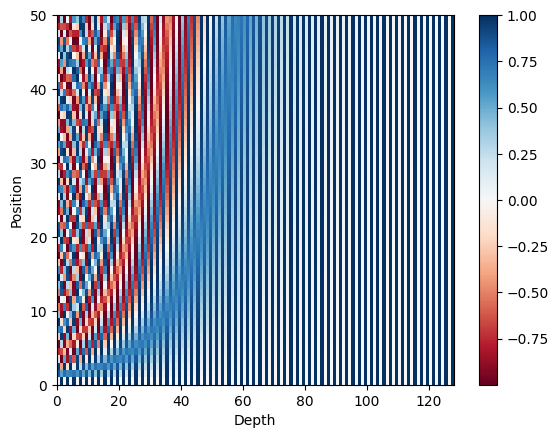

In [10]:
example_dec = Encoder(1000, 128, 6, 8, 2048, 0.1, 140, device)
pe = example_dec.position_encoding(140)[:, :50, :].squeeze()

import matplotlib.pyplot as plt

plt.pcolormesh(pe, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Transformer

In [46]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, source_pad_idx, target_pad_idx,
                 d_model, layer_num, ff_dim, head_num, dropout_p, device, max_length):
        super().__init__()

        self.source_pad_idx = source_pad_idx
        self.target_pad_idx = target_pad_idx

        self.device = device

        self.encoder = Encoder(input_dim,
                               d_model,
                               layer_num,
                               head_num,
                               ff_dim,
                               dropout_p,
                               device,
                               max_length)
        self.decoder = Decoder(output_dim,
                               d_model,
                               layer_num,
                               head_num,
                               ff_dim,
                               dropout_p,
                               device,
                               max_length)

        self.fc_out = nn.Linear(d_model, output_dim)

    # padding에 대한 mask 생성
    def make_padding_mask(self, query, key):
        # query: [batch_size, query_len]
        # key: [batch_size, key_len]

        query_len, key_len = query.size(-1), key.size(-1)

        key_mask = (key != self.source_pad_idx).unsqueeze(1).unsqueeze(2)
        # [batch_size, 1, 1, key_len]
        key_mask = key_mask.repeat(1, 1, query_len, 1).type(torch.uint8) # 차원을 입력 인자만큼 반복
        # key_mask: [batch_size, 1, query_len, key_len]

        key_mask.requires_grad = False # 학습 대상 아님

        return key_mask

    # look ahead에 대한 mask 생성
    def make_look_ahead_mask(self, query, key):
        # query: [batch_size, query_len]
        # key: [batch_size, key_len]

        query_len, key_len = query.size(-1), key.size(-1)

        # lower triangle
        tril = np.tril(np.ones((query_len, key_len)), k=0).astype('uint8')
        mask = torch.tensor(tril, requires_grad=False, device=self.device) # 학습 대상 아님
        # mask: [query_len, key_len]

        return mask

    # Decoder self-attention에 적용할 mask 생성
    def make_target_mask(self, target):

        pad_mask = self.make_padding_mask(target, target).to(target.device)
        seq_mask = self.make_look_ahead_mask(target, target).to(target.device)
        # decoder에서는 subsequent masking이 적용되어야 한다

        mask = pad_mask & seq_mask # 비트 연산
        # 동시에 pad mask도 적용되어야 한다

        return pad_mask & seq_mask



    def encode(self, source):
        '''
        Test 용도로 활용 (Encoder 기능)
        '''
        source_mask = self.make_padding_mask(source, source)

        return self.encoder(source, source_mask)

    def decode(self, source, target, enc_out):
        '''
        Test 용도로 활용 (Decoder 기능)
        '''
        # Decode
        source_target_mask = self.make_padding_mask(target, source)
        target_mask = self.make_target_mask(target)
        output = self.decoder(target, enc_out, target_mask, source_target_mask)

        # Linear
        output = self.fc_out(output)
        # output: [batch_size, target_seq_len, d_model]

        # softmax
        output = F.log_softmax(output, dim=-1)

        return output



    def forward(self, source, target):
        # source: [batch_size, source_seq_len]
        # target: [batch_size, target_seq_len]

        source_mask = self.make_padding_mask(source, source) # Encoder Self-Attention
        target_mask = self.make_target_mask(target) # Decoder Self-Attention
        source_target_mask = self.make_padding_mask(target, source) # Encoder-Decoder Attention

        # source_mask: [batch_size, 1, 1, source_seq_len]
        # target_mask: [batch_size, 1, target_seq_len, target_seq_len]
        # source_target_mask: [batch_size, 1, target_seq_len, source_seq_len]

        source_encoding = self.encoder(source, source_mask)
        # source_encoding: [batch_size, source_seq_len, d_model]

        output = self.decoder(target, source_encoding, target_mask, source_target_mask)
        # output: [batch_size, target_seq_len, d_model]

        # Linear 적용
        output = self.fc_out(output)
        # output: [batch_size, target_seq_len, output_dim]

        # Softmax 적용
        output = F.log_softmax(output, dim=-1)

        return output

In [12]:
test_model = Transformer(10000, 10000, 1, 1,
                        128, 3, 256, 8, 0.1, 'cuda', 140).to(device)

src = torch.tensor([[3, 5, 12, 3, 5, 7, 8, 1, 1, 1]])
trg = torch.tensor([[4, 5, 6, 7, 6, 1, 1]])

y_1 = test_model.make_padding_mask(src, src)
y_2 = test_model.make_target_mask(trg)
y_3 = test_model.make_padding_mask(trg, src)

print(y_1)
print(y_2)
print(y_3)

tensor([[[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=torch.uint8)
tensor([[[[1, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 0, 0]]]], dtype=torch.uint8)
tensor([[[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=to

# Train

## utils

In [13]:
!pip install torchtext==0.13.1

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [15]:
def open_text_set(dir: str) -> list:
    """
    train, validation 파일 오픈 용도

    dir : 파일경로
    """

    with open(dir, "r") as f:
        f = f.readlines()
        f = [v.rstrip() for v in f]

    return f


def make_vocab(
    src_lang: Iterable,
    trg_lang: Iterable,
) -> list:
    """
    Word embedding을 위한 vocab 생성(sub_word embedding X)
    src_lang : input 언어
    trg_lang : output 언어

    """

    token_transform = {}
    vocab_transform = {}

    SRC_LANGUAGE, TRG_LANGUAGE = ["fr", "en"]
    # Load_tokenizer
    token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="fr_core_news_sm")
    token_transform[TRG_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")

    # token 생성을 위한 iterator 생성
    def yield_tokens(data_iter: Iterable, language: str) -> List[str]:

        for data_sample in data_iter:
            yield token_transform[language](data_sample)  # memory 초과 방지용으로 yield 사용

    # special tokens
    UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
    special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

    for train_iter, ln in [(src_lang, SRC_LANGUAGE), (trg_lang, TRG_LANGUAGE)]:

        # 언어별 vocab 생성
        vocab_transform[ln] = build_vocab_from_iterator(
            yield_tokens(train_iter, ln),
            min_freq=1,
            specials=special_symbols,
            special_first=True,
        )

    # OOV가 존재하면 <unk>을 반환하도록 default idx 설정
    # defualt idx 를 설정해야 OOV 문제에서 에러가 발생하지 않음

    for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
        vocab_transform[ln].set_default_index(UNK_IDX)

    # vocab, tokenizer 저장
    return [vocab_transform, token_transform]


def sequential_transforms(*transforms):
    """
    *transform에 포함된 함수를 연속적으로 수행하게 하는 메서드.
    """

    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


def tensor_transform(token_ids: List[int]):
    """
    토크나이징 한 문장에 시작과 끝을 의미하는 Special Token(<bos>, <eos>) 추가
    bos_idx = 2, eos_idx = 3
    """
    return torch.cat((torch.tensor([2]), torch.tensor(token_ids), torch.tensor([3])))

In [16]:
from torch.utils.data import Dataset

class fr_to_en(Dataset):
    """
    pytorch dataloader 사용을 위한 class
    """

    def __init__(self, set_type):
        super().__init__()
        if set_type == "training":
            self.src_lang = open_text_set("/content/drive/MyDrive/train.fr")
            self.trg_lang = open_text_set("/content/drive/MyDrive/train.en")

            print('► Dataset is "training"')

        elif set_type == "validation":
            self.src_lang = open_text_set("/content/drive/MyDrive/val.fr")
            self.trg_lang = open_text_set("/content/drive/MyDrive/val.en")

            print('► Dataset is "validation"')

        else:
            raise ValueError('set_type must be "training" or "validation"')

    def __len__(self):
        return len(self.src_lang)

    def __getitem__(self, idx):
        return self.src_lang[idx], self.trg_lang[idx]

## Vocab 만들기

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# 훈련 데이터 불러오기
# Fr -> En 번역을 위한 데이터셋(Multi-30k) 활용
fr_train = open_text_set("/content/drive/MyDrive/train.fr")
en_train = open_text_set("/content/drive/MyDrive/train.en")

# Vocab 만들기 / 관련 함수는 utils 참조
try :
  vocab_transform, token_transform = make_vocab(fr_train, en_train)
except :
  # 오류 발생 시 spacy 설치 필요

  # spacy tokenizer 다운로드(en,fr)
  import spacy.cli
  spacy.cli.download("en_core_web_sm")
  spacy.cli.download("fr_core_news_sm")
  vocab_transform, token_transform = make_vocab(fr_train, en_train)

# param
SRC_LANGUAGE = "fr"
TGT_LANGUAGE = "en"

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Model 만들기

In [71]:
SRC_VOCAB_SIZE = 11509
TRG_VOCAB_SIZE = 10837

PAD_IDX = 1

D_MODEL = 512
LAYER_NUM = 3
FF_DIM = 1024
HEAD_NUM = 8

DROPOUT_P = 0.1

SEQ_LEN = 140

In [72]:
model = Transformer(SRC_VOCAB_SIZE, TRG_VOCAB_SIZE, PAD_IDX, PAD_IDX,
                    D_MODEL, LAYER_NUM, FF_DIM, HEAD_NUM, DROPOUT_P, device, SEQ_LEN).to(device)

In [73]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (input_embedding): Embedding(11509, 512)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (positionwise_feedforward): PositionwiseFeedForward(
          (fc_1): Linear(in_features=512, out_features=1024, bias=True)
          (fc_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (self_attention_layer_norm): LayerNorm((512,), eps=1e-05, 

In [74]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Model 구조 확인

In [76]:
from torchsummary import summary

test1 = torch.randint(low=0, high=1000, size=(SEQ_LEN,))
test2 = torch.randint(low=0, high=1000, size=(SEQ_LEN,))

summary(model, [(SEQ_LEN,), (SEQ_LEN,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 140, 512]       5,892,608
           Dropout-2             [-1, 140, 512]               0
            Linear-3             [-1, 140, 512]         262,656
            Linear-4             [-1, 140, 512]         262,656
            Linear-5             [-1, 140, 512]         262,656
            Linear-6             [-1, 140, 512]         262,656
MultiHeadAttention-7             [-1, 140, 512]               0
           Dropout-8             [-1, 140, 512]               0
         LayerNorm-9             [-1, 140, 512]           1,024
           Linear-10            [-1, 140, 1024]         525,312
           Linear-11             [-1, 140, 512]         524,800
PositionwiseFeedForward-12             [-1, 140, 512]               0
          Dropout-13             [-1, 140, 512]               0
        LayerNorm-14             

## Train & Validation 설정

In [77]:
def collate_fn(batch_iter: Iterable):
    """
    Data_loader에서 불러온 데이터를 가공하는 함수
    토크나이징 => encoding => 시작 끝을 의미하는 spectial token(<bos>,<eos>) 추가 순으로 진행
    """
    text_transform = {}
    for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
        text_transform[ln] = sequential_transforms(
            token_transform[ln],  # 토크나이징
            vocab_transform[ln],  # encoding
            tensor_transform, # BOS/EOS를 추가하고 텐서를 생성
        )
        # sequential_transform, tensor_transform은 utils.py 참고

    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch_iter:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample))

    # Pad 붙이기
    PAD_IDX = 1
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.T, tgt_batch.T

# token을 단어로 바꾸기 위한 dict 생성, vocab의 key와 value 위치 변경
# 아래 helper 함수에서 활용됨.
decoder_en = {v:k for k,v in vocab_transform['en'].get_stoi().items()}
decoder_fr = {v:k for k,v in vocab_transform['fr'].get_stoi().items()}


def helper_what_sen(src,trg,logits,i,c=100,sen_num=0) :
    '''
    문장이 제대로 학습되고 있는지를 확인하는 함수

    src = encoding 된 source_sentence
    trg = encoding 된 target_sentence
    logits = 모델 예측값
    i = 현재 batch 순서
    c = 결과를 보여주는 단계, ex) c = 100이면 100,200,300... 번째 batch에서 결과를 보여줌
    sen_num = batch 내 문장 중 몇 번째 문장을 추적할 것인지 설정
    '''
    if i % c == 0 and i != 0 :
        src_sen = ' '.join([decoder_fr[i] for i in src.tolist()[sen_num] if decoder_fr[i][0] != '<' ])
        trg_sen = ' '.join([decoder_en[i] for i in trg.tolist()[sen_num] if decoder_en[i][0] != '<' ])
        prediction = logits.max(dim=-1, keepdim=False)[1][sen_num]
        prd_sen = ' '.join([decoder_en[i] for i in prediction.tolist() if decoder_en[i] != '<' ])
        '''
        /*/* 모델의 예측 문장(prd_sen)을 구하는 방법 /*/*

        n = batch size, trg_token_len = batch 내 문장의 최대 토큰 개수

        모델 output(=logits)은 (n, trg_token_len, trg_vocab_len)의 3차원 텐서임.

        1. 해당 텐서를 trg_vocab_len 차원의 기준으로 max를 하면 (n,trg_token_len)을 반환
        2. tensor.max()의 수행 결과는 [최댓값,idx]를 반환함.
        3. [1]을 넣어 idx를 선택, 그 결과는 (n, trg_token_len) 차원의 idx 반환
        4. 원하는 문장 순서(sen_num)을 선택한 뒤 정수를 다시 단어로 decoding 수행
        '''

        print('')
        print(f'{i}번째 batch에 있는 {sen_num}번째 문장 예측 결과 확인')
        print('src : ',src_sen)
        print('prd : ',prd_sen)
        print('trg : ',trg_sen)
        print('')

    return None

def train_epoch(model,optimizer) :
    '''
    훈련 과정 설정
    '''
    # 모델 훈련 모드 변경
    model.train()
    losses = 0

    # training 데이터 불러오기(29,000개 문장)
    dataset= fr_to_en(set_type='training')

    # Data_loader
    batch_size = 128
    train_dataloader = DataLoader(dataset,batch_size,collate_fn=collate_fn)

    # 128개 문장을 1개의 batch로 총 227번 반복(128*227 => 29,000)

    for i,(src,tgt) in enumerate(train_dataloader) :
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:,:-1] # 마지막 token은 <eos> 또는 <pad>이므로 불필요한 데이터 전처리

        logits = model(src,tgt_input) # (n, trg_token_len, trg_vocab_len) 3

        optimizer.zero_grad()

        helper_what_sen(src,tgt_input,logits,i,200,0) # 학습상태 확인

        tgt_output = tgt[:,1:] # 첫번째 token은 <bos>이므로 불필요한 데이터 전처리
        loss = loss_fn(logits.reshape(-1,logits.shape[-1]),tgt_output.reshape(-1))
        '''
        */*/*/*/ loss_fn(model_output,target_out_put) 설명 */*/*/*/*/*/

        model_output은 (n, trg_token_len, trg_vocab_len)의 3차원 텐서임
        target_output은 (n,trg_token_len)의 2차원 텐서임
        이를 각각 2차원, 1차원으로 줄이면
        model_output = (n*trg_token_len, trg_vocab_len)
        target_output = (n*trg_token_len)

        이때 target_output은 개별 단어의 idx이므로
        model_output의 model_outpu의 idx로 활용하면 해당 단어의 확률을 찾을 수 있음.

        이러한 방법으로 정답인 단어와, 정답이 아닌 단어를 구분하여 Loss 계산 수행
        '''

        loss.backward()

        optimizer.step()

        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    #모델 평가모드
    model.eval()
    losses = 0

    # Load_Dataset
    dataset= fr_to_en(set_type='validation')

    # validation 데이터 불러오기
    batch_size = 128
    val_dataloader = DataLoader(dataset,batch_size,collate_fn=collate_fn)

    for i,(src,tgt) in enumerate(val_dataloader) :

        src = src.to(device)
        tgt = tgt.to(device)
        tgt_input = tgt[:,:-1]

        logits = model(src,tgt_input)

        helper_what_sen(src,tgt_input,logits,i,5,0) # 학습상태 확인

        tgt_output = tgt[:,1:]
        loss = loss_fn(logits.reshape(-1,logits.shape[-1]),tgt_output.reshape(-1))

        losses += loss.item()

    return losses / len(val_dataloader)

## 학습 및 평가 진행

In [78]:
from timeit import default_timer as timer
NUM_EPOCHS = 50

for epoch in range(1, NUM_EPOCHS+1):
    print('-'*30)
    print(f'{epoch}번째 epoch 실행')
    start_time = timer()
    train_loss = train_epoch(model.to(device), optimizer)
    end_time = timer()
    val_loss = evaluate(model)


    print('----*'*20)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    print('----*'*20)
    print('')

------------------------------
1번째 epoch 실행
► Dataset is "training"

200번째 batch에 있는 0번째 문장 예측 결과 확인
src :  Un homme en uniforme orange pose au milieu d' une rue .
prd :  A man in a a a a a a a . . . . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
trg :  A man in an orange uniform poses in the middle of a street .

► Dataset is "validation"

5번째 batch에 있는 0번째 문장 예측 결과 확인
src :  Un vieil homme est assis avec un plateau sur ses genoux .
prd :  A man in a a a a a a . . <eos> . . . . . . <eos> <eos> <eos> <eos> . . . <eos> <eos>
trg :  An old man sits with a tray in his lap .

----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*
Epoch: 1, Train loss: 5.669, Val loss: 4.892, Epoch time = 36.346s
----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*----*

------------------------------
2번째 epoch 실행
► Dataset is "training"

200번째 batch에 있는 0번째 문장 예측 결과 확인

In [79]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_state_dict.pt')

# Test

## utils

In [47]:
!pip install torchtext==0.13.1

In [48]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
import torch

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [49]:
def open_text_set(dir: str) -> list:
    """
    train, validation 파일 오픈 용도

    dir : 파일경로
    """

    with open(dir, "r") as f:
        f = f.readlines()
        f = [v.rstrip() for v in f]

    return f


def make_vocab(
    src_lang: Iterable,
    trg_lang: Iterable,
) -> list:
    """
    Word embedding을 위한 vocab 생성(sub_word embedding X)
    src_lang : input 언어
    trg_lang : output 언어

    """

    token_transform = {}
    vocab_transform = {}

    SRC_LANGUAGE, TRG_LANGUAGE = ["fr", "en"]
    # Load_tokenizer
    token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="fr_core_news_sm")
    token_transform[TRG_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")

    # token 생성을 위한 iterator 생성
    def yield_tokens(data_iter: Iterable, language: str) -> List[str]:

        for data_sample in data_iter:
            yield token_transform[language](data_sample)  # memory 초과 방지용으로 yield 사용

    # special tokens
    UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
    special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

    for train_iter, ln in [(src_lang, SRC_LANGUAGE), (trg_lang, TRG_LANGUAGE)]:

        # 언어별 vocab 생성
        vocab_transform[ln] = build_vocab_from_iterator(
            yield_tokens(train_iter, ln),
            min_freq=1,
            specials=special_symbols,
            special_first=True,
        )

    # OOV가 존재하면 <unk>을 반환하도록 default idx 설정
    # defualt idx 를 설정해야 OOV 문제에서 에러가 발생하지 않음

    for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
        vocab_transform[ln].set_default_index(UNK_IDX)

    # vocab, tokenizer 저장
    return [vocab_transform, token_transform]


def sequential_transforms(*transforms):
    """
    *transform에 포함된 함수를 연속적으로 수행하게 하는 메서드.
    """

    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


def tensor_transform(token_ids: List[int]):
    """
    토크나이징 한 문장에 시작과 끝을 의미하는 Special Token(<bos>, <eos>) 추가
    bos_idx = 2, eos_idx = 3
    """
    return torch.cat((torch.tensor([2]), torch.tensor(token_ids), torch.tensor([3])))

In [50]:
from torch.utils.data import Dataset

class fr_to_en(Dataset):
    """
    pytorch dataloader 사용을 위한 class
    """

    def __init__(self, set_type):
        super().__init__()
        if set_type == "training":
            self.src_lang = open_text_set("/content/drive/MyDrive/train.fr")
            self.trg_lang = open_text_set("/content/drive/MyDrive/train.en")

            print('► Dataset is "training"')

        elif set_type == "validation":
            self.src_lang = open_text_set("/content/drive/MyDrive/val.fr")
            self.trg_lang = open_text_set("/content/drive/MyDrive/val.en")

            print('► Dataset is "validation"')

        else:
            raise ValueError('set_type must be "training" or "validation"')

    def __len__(self):
        return len(self.src_lang)

    def __getitem__(self, idx):
        return self.src_lang[idx], self.trg_lang[idx]

## Vocab 생성

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# 훈련 데이터 불러오기
# Fr -> En 번역을 위한 데이터셋(Multi-30k) 활용
fr_data = open_text_set("/content/drive/MyDrive/train.fr")
eng_data = open_text_set("/content/drive/MyDrive/train.en")

# Vocab 만들기 / 관련 함수는 utils.py 참조
try :
  vocab_transform, token_transform = make_vocab(fr_data, eng_data)
except :
  # 오류 발생 시 spacy 설치 필요

  # spacy tokenizer 다운로드(en,fr)
  import spacy.cli
  spacy.cli.download("en_core_web_sm")
  spacy.cli.download("fr_core_news_sm")
  vocab_transform, token_transform = make_vocab(fr_data, eng_data)

# param
SRC_LANGUAGE = "fr"
TGT_LANGUAGE = "en"

## 학습된 모델 불러오기

In [60]:
SRC_VOCAB_SIZE = 11509
TRG_VOCAB_SIZE = 10837

PAD_IDX = 1

D_MODEL = 512
LAYER_NUM = 3
FF_DIM = 1024
HEAD_NUM = 8

DROPOUT_P = 0.1

SEQ_LEN = 140

In [61]:
loaded_model = Transformer(SRC_VOCAB_SIZE, TRG_VOCAB_SIZE, PAD_IDX, PAD_IDX,
                           D_MODEL, LAYER_NUM, FF_DIM, HEAD_NUM, DROPOUT_P, device, SEQ_LEN).to(device)
model_state_dict = torch.load('/content/drive/MyDrive/model_state_dict.pt')
loaded_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [62]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## 모델 테스트

In [65]:
# token을 단어로 바꾸기 위한 dict 생성, vocab의 key와 value 위치 변경
# 아래 helper 함수에서 활용됨.
decoder_en = {v:k for k,v in vocab_transform['en'].get_stoi().items()}
decoder_fr = {v:k for k,v in vocab_transform['fr'].get_stoi().items()}

def tokenizing_src(input_data:str) :
    # input_data_tokenizing
    token_data = token_transform['fr'](input_data)
    vocab_src = vocab_transform['fr'](token_data)
    tokenized_src = [2] + vocab_src + [3]
    return tokenized_src

def select_random_item() :
    num = torch.randint(1,29000,(1,)).item()

    return fr_data[num], eng_data[num]

def test(model) :
    '''
    * validation은 문제와 정답이 모두 주어진다면 test는 문제만 제공하는 상황임.

    * test 함수를 통해 Transformer의 실제 문제 예측 과정을 이해할 수 있음.

    * Transformer는 문제와 정답이 있다면 답을 구하는 과정을 병렬적으로 수행할 수 있음.

    * 하지만 테스트에서는 정답이 주어지지 않으므로 한 번의 하나의 토큰을 생산함.

    * < bos > token을 시작으로 다음 토큰을 예상하며 < eos > 토큰이 생성될때까지 반복적으로 예측을 수행하게 되는 알고리즘이 필요함.

    * 아래의 test 함수를 다뤄보면서 Transformer의 데이터 처리 과정을 이해할 수 있음.

    '''

    model.eval()

    # 임의의 훈련 데이터 선별
    fr_item, en_item = select_random_item()

    print('입력 :', fr_item)

    # Input Data 토크나이징
    tokenized_input = tokenizing_src(fr_item)
    max_length = int(len(tokenized_input) * 1.2)

    # src Tensor에 Token 저장
    src = torch.LongTensor(tokenized_input).unsqueeze(0).to(device)

    # trg Tensor 생성(1, max_length)
    trg = torch.zeros(1,max_length).type_as(src.data).to(device)

    # src encoding
    enc_src = model.encode(src)

    next_trg = 2 # 문장 시작 <bos> idx

    # 문장 예측 시작
    for i in range(0,max_length) :
        trg[0][i] = next_trg # token 저장

        logits = model.decode(src,trg,enc_src) # output 산출

        prd = logits.squeeze(0).max(dim=-1, keepdim=False)[1] # 예측 단어 중 max 추출
        next_word = prd.data[i] # i 번째 위치한 단어 추출
        next_trg = next_word.item()
        if next_trg == 3 :
            # <eos> 나오면 종료
            trg[0][i] = next_trg
            break

    # <pad> 제거
    if 3 in trg[0] :
        eos_idx = int(torch.where(trg[0] == 3)[0][0])
        trg = trg[0][:eos_idx].unsqueeze(0)
    else :
        pass

    # 번역
    translation = [decoder_en[i] for i in trg.squeeze(0).tolist()]
    print('모델예측 :',' '.join(translation[1:]))


    print('정답 :', en_item)
    print('')
    print('제한된 데이터로 학습을 수행했으므로 완벽한 예측이 불가능함.')


test(loaded_model)

입력 : Un chien blanc court dans un chemin entre les buissons.
모델예측 : A white dog is running through a path between bushes
정답 : A white dog is running down a path between bushes.

제한된 데이터로 학습을 수행했으므로 완벽한 예측이 불가능함.
